## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Esh: A Novel Activation Function for Improved Neural Network Performance</p>

Activation functions play a crucial role in the performance of neural networks by introducing non-linearity and allowing the network to learn complex relationships in the data. In this paper, we present Esh, a new activation function that is designed to improve the accuracy and efficiency of neural networks. 

Esh is defined as the hyperbolic tangent (tanh) of the sigmoid function applied to the input x and is based on the popular Mish function, but with a more gradual slope that helps it to better retain low-level features in the input data.
Esh is defined to be

$$
\text{Esh}(x) = x \tanh(\text{sigmoid}(x))
$$
where $\text{sigmoid}(x)=1/(1+e^{-x})$.

<br>

<br>
<center>
<img src='https://i.postimg.cc/HLcZVRHV/Novel-AFs-V1.png' width=650> 
<figcaption>Proposed AFs</figcaption>
<br>
<br>

To evaluate the effectiveness of Esh, we conducted experiments using a convolutional neural network (CNN) trained on the MNIST dataset, as well as the VGG16 and ResNet20 architectures on the CIFAR-10  dataset. We compared the performance of Esh to the ReLU, Swish, and Mish activation functions as baselines.
    
<br>
<center>
<img src='https://i.postimg.cc/NGHFRPbY/AFs-Known.png'
<figcaption>Proposed Esh vs Other AFs</figcaption>
<br>    

In [2]:
!pip install -Uq wandb
!pip install -Uq tensorflow-addons 

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">Implementation</p>

In [3]:
from keras.applications import VGG16
from keras.layers import Activation
from keras.models import Model
from keras import backend as K
import tensorflow as tf
import tensorflow.keras as keras
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.datasets import cifar100, cifar10
import tensorflow_addons as tfa
from tensorflow.keras import layers
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
from keras.utils.generic_utils import get_custom_objects
from keras.activations import swish, leaky_relu, relu, gelu, elu, softplus, softsign

import pandas as pd
import numpy as np
import time
import random
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', font_scale=1.6, rc={"figure.dpi":250, 'savefig.dpi':250})

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import optimizers
import numpy as np
from keras.layers.core import Lambda
from keras import backend as K
from keras import regularizers

import wandb
from wandb.keras import WandbCallback

C:\Users\sures\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
# Set random seeds
def set_seed(seed=2):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

In [5]:
# Define the Esh activation function
def esh(x):
    return x * K.tanh(K.sigmoid(x))

def mish(x):
    return tfa.activations.mish(x)

get_custom_objects().update({'mish': Activation(mish)})
get_custom_objects().update({'esh': Activation(esh)})

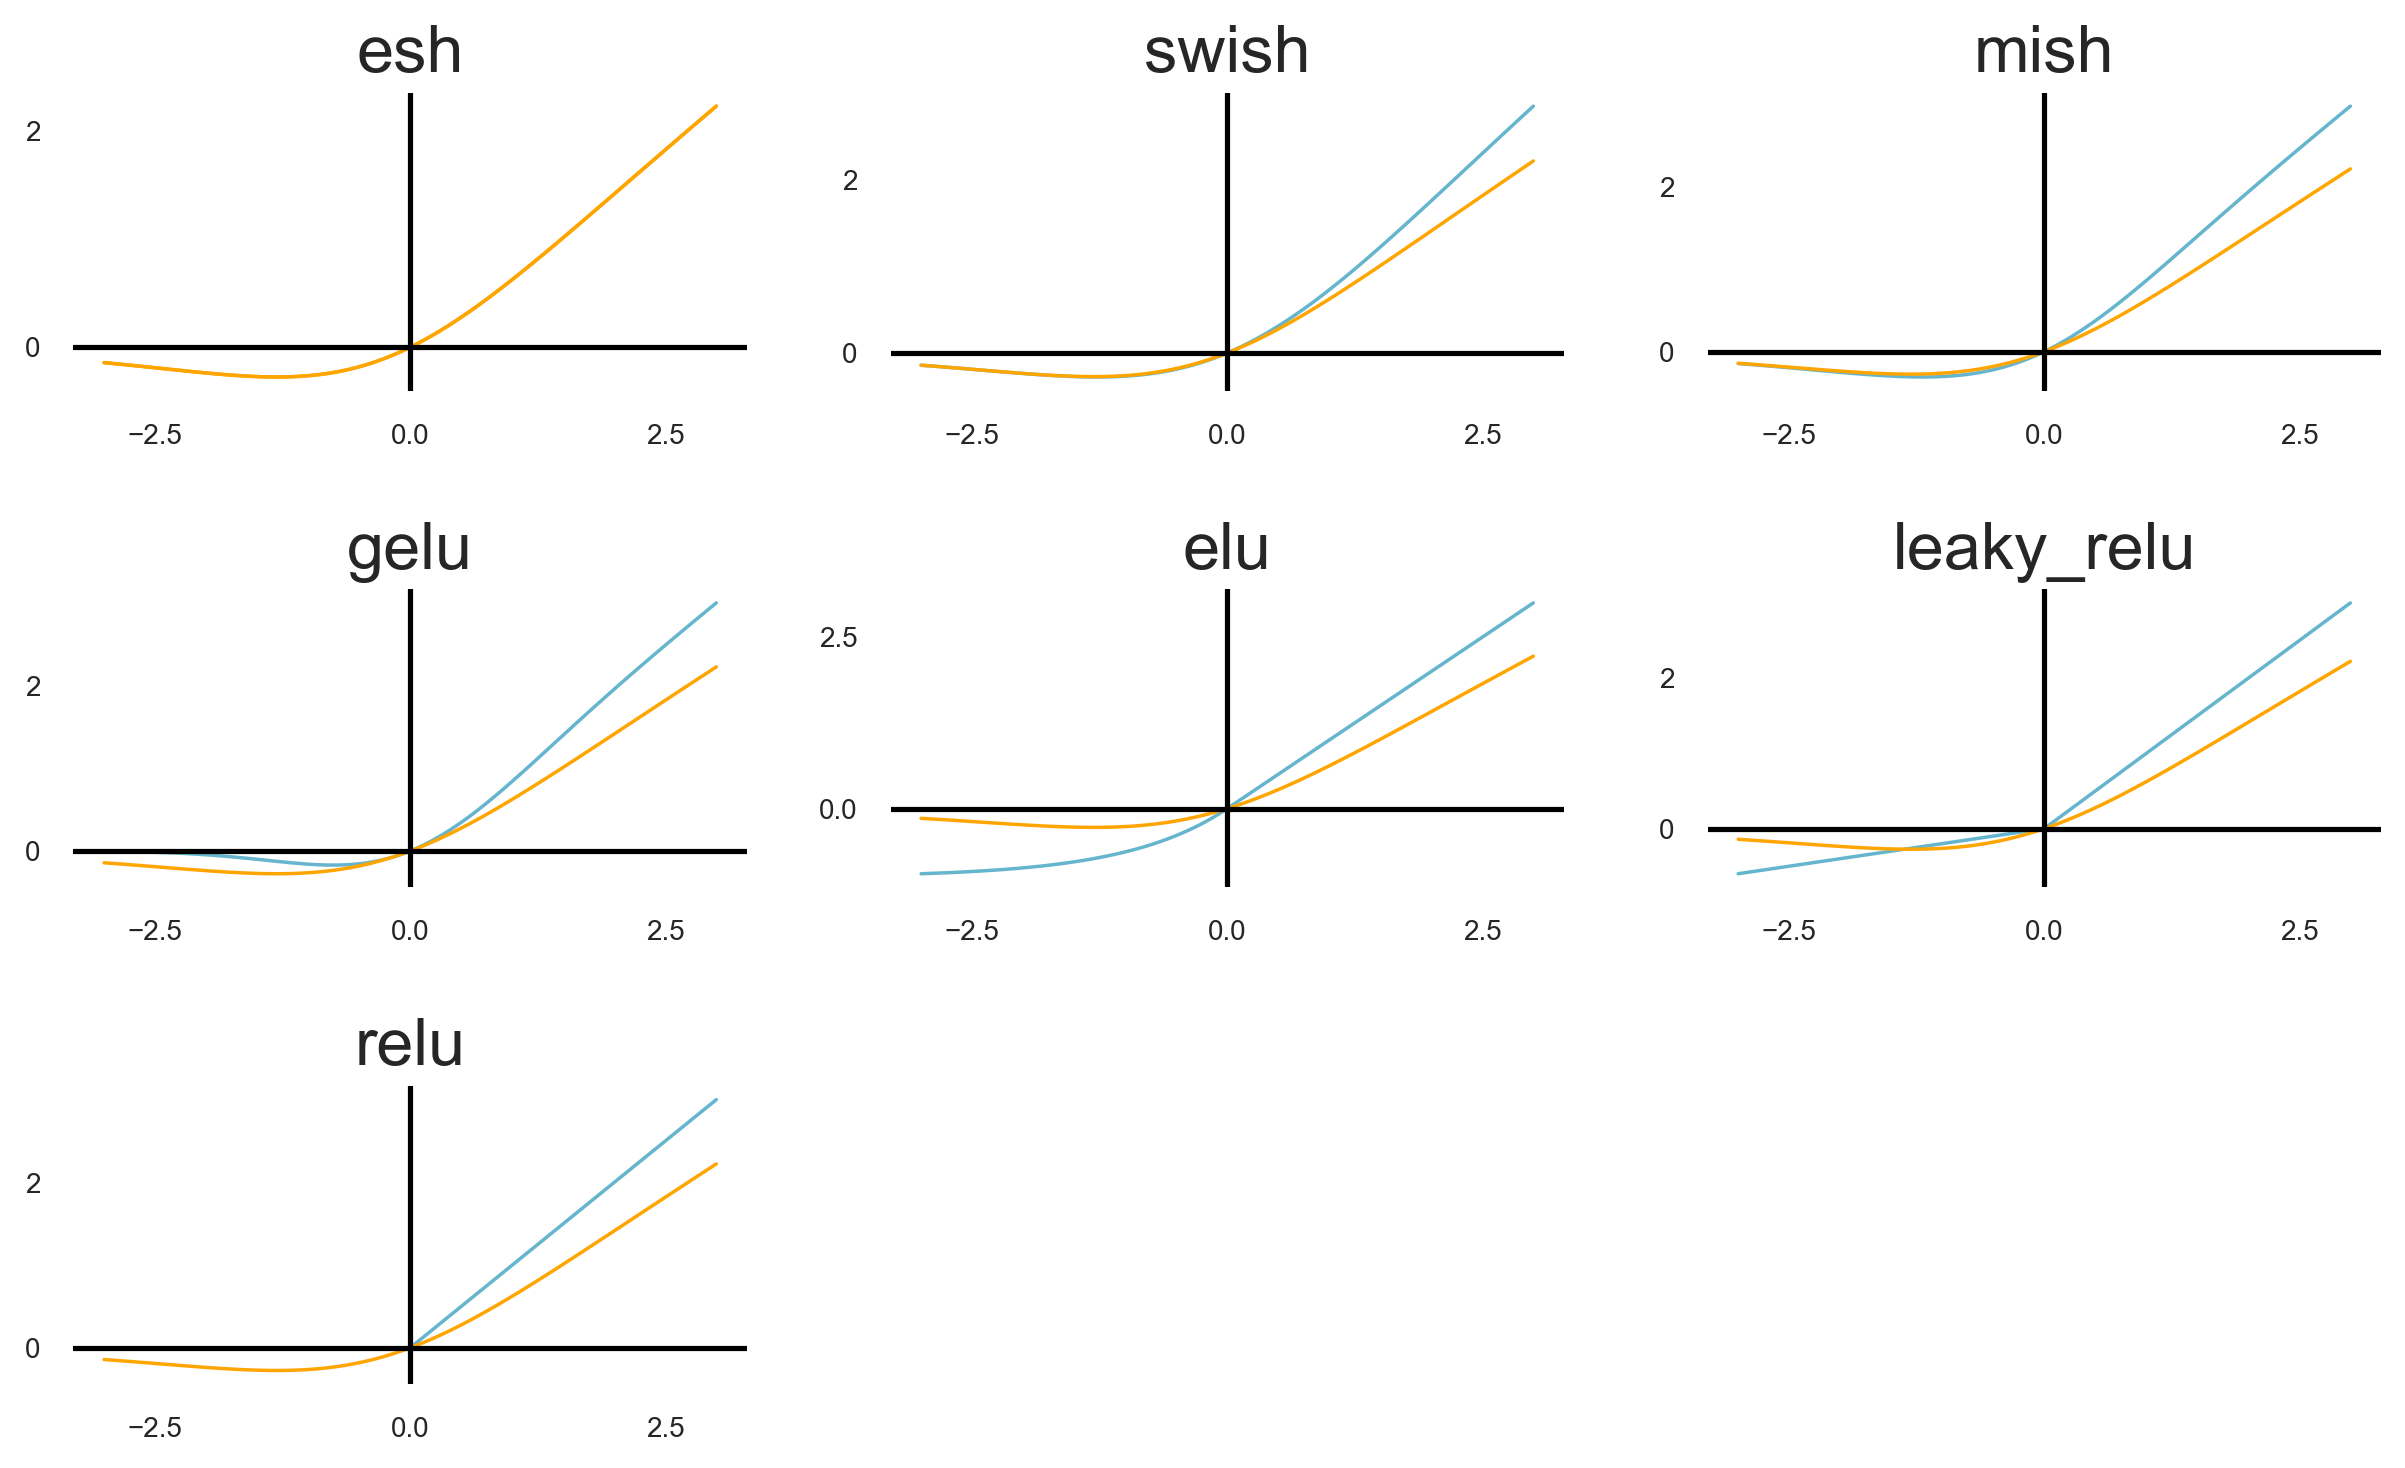

In [6]:
#### Grid
xx = np.linspace(start=-3,stop=3,num=100)
afs = [esh, swish, mish, gelu, elu, leaky_relu, relu]

#### Plot activation functions
plt.figure(figsize=(10,8))
for i, act_fuct in enumerate(afs):
    c = 'c'
    if act_fuct.__name__ == 'esh':
        c = 'orange'
    plt.subplot(4,3,i+1)
    plt.plot(xx,act_fuct(xx), color=c, linewidth=1)
    plt.plot(xx,esh(xx), color='orange', linewidth=1)
    plt.axhline(color='black')
    plt.axvline(color='black')
    plt.title(act_fuct.__name__)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

plt.tight_layout()
sns.despine(bottom=True,left=True)
plt.show()

In [7]:
#settings
img_shape = (32, 32, 3)
batch_size = 32
n_classes = 10
epochs = 200
version_string = 'v1_cifar10'

from keras.optimizers import SGD
optimizer = Adam()

loss = 'categorical_crossentropy'
metrics = ['accuracy']
verbose=1
early_stop_patience = epochs

In [8]:
sweep_config = {
    'method': 'grid',
    'metric': {
        'name': 'loss',
        'goal': 'minimize'
    },
    'parameters': {
        'act': {
            'values': ['esh', 'relu', 'gelu', 'mish']
        },

    }
}

In [9]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalise and reshape arrays
x_train, x_test = x_train.reshape((-1, 784))/255.0, x_test.reshape((-1, 784))/255.0

# Print shapes
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [10]:
def build_mnist_model(act_func='esh', depth=15, dropout = 0.25, units = 50):  
    # Sequential model
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(784,)))
    
    # Hidden layers
    for i in range(depth-1):
        model.add(layers.Dense(units))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(act_func))
        model.add(layers.Dropout(rate=dropout))
    
    # Output layer
    model.add(layers.Dense(units=10, activation='softmax'))
       
    return model

In [ ]:
def build_vgg_model(act_func='esh', depth=15, dropout = 0.25, units = 50):  
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same',
                     input_shape=img_shape,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Flatten())
    model.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation(act_func))
    model.add(BatchNormalization())

    model.add(Dropout(0.5))
    model.add(Dense(n_classes))
    model.add(Activation('softmax'))
    model.summary()
    return model

In [11]:
def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, )

In [12]:
def train(model, epochs=10, lr=1e-3, optimizer='sgd', log_freq=10):  
    
    tf.keras.backend.clear_session()
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=get_optimizer(lr, optimizer), 
                  metrics=["sparse_categorical_accuracy"])

    # callback setup
    wandb_callbacks = [WandbCallback(compute_flops=True, 
                                     log_freq = log_freq, 
                                     save_best_only=True,
                                     validation_data=(x_test, y_test))]
    
    model.fit(x_train, 
              y_train, 
              batch_size=batch_size, 
              epochs=epochs, 
              validation_data=(x_test, y_test), 
              callbacks=wandb_callbacks)

In [13]:
def sweep_train(config_defaults=None):

    with wandb.init(config=config_defaults):  

        wandb.config.architecture_name = "NN"
        wandb.config.dataset_name = "MNIST"

        # initialize model
        model = build_mnist_model(act_func=wandb.config.act, 
                                  depth=wandb.config.depth, 
                                  dropout = wandb.config.dropout)

        train(model, 
              wandb.config.epochs,
              wandb.config.learning_rate,
              wandb.config.optimizer
             )

In [ ]:
%env "WANDB_NOTEBOOK_NAME" "NN_MNIST_WB"


wandb.login() #a96eb1d17152292d104d045304f8da02ab8fe0e1

sweep_id = wandb.sweep(sweep_config, project="NN_MNIST_WB_Final_v1")

wandb.agent(sweep_id, function=sweep_train)

env: "WANDB_NOTEBOOK_NAME"="NN_MNIST_WB"


wandb: Currently logged in as: rsuresh002 (pes_mtech_jun21_g3). Use `wandb login --relogin` to force relogin


Create sweep with ID: lopuy9zb
Sweep URL: https://wandb.ai/pes_mtech_jun21_g3/NN_MNIST_WB_Final_v1/sweeps/lopuy9zb


wandb: Agent Starting Run: 3yhvjuax with config:
wandb: 	act: esh
wandb: 	depth: 15
wandb: 	dropout: 0.25
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
Epoch 1/40
1872/1875 [============================>.] - ETA: 0s - loss: 2.1992 - sparse_categorical_accuracy: 0.1817INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 10ms/step - loss: 2.1990 - sparse_categorical_accuracy: 0.1816 - val_loss: 1.8823 - val_sparse_categorical_accuracy: 0.2976
Epoch 2/40
1867/1875 [============================>.] - ETA: 0s - loss: 1.7638 - sparse_categorical_accuracy: 0.3507INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 10ms/step - loss: 1.7629 - sparse_categorical_accuracy: 0.3512 - val_loss: 1.2440 - val_sparse_categorical_accuracy: 0.5548
Epoch 3/40
1871/1875 [============================>.] - ETA: 0s - loss: 1.4538 - sparse_categorical_accuracy: 0.4690INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 1.4535 - sparse_categorical_accuracy: 0.4692 - val_loss: 0.8908 - val_sparse_categorical_accuracy: 0.6915
Epoch 4/40
1872/1875 [============================>.] - ETA: 0s - loss: 1.2678 - sparse_categorical_accuracy: 0.5376INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 1.2682 - sparse_categorical_accuracy: 0.5375 - val_loss: 0.7332 - val_sparse_categorical_accuracy: 0.7664
Epoch 5/40
1869/1875 [============================>.] - ETA: 0s - loss: 1.1719 - sparse_categorical_accuracy: 0.5771INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 10ms/step - loss: 1.1719 - sparse_categorical_accuracy: 0.5772 - val_loss: 0.6662 - val_sparse_categorical_accuracy: 0.7797
Epoch 6/40
1860/1875 [============================>.] - ETA: 0s - loss: 1.0999 - sparse_categorical_accuracy: 0.6095INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 1.0996 - sparse_categorical_accuracy: 0.6094 - val_loss: 0.6069 - val_sparse_categorical_accuracy: 0.8036
Epoch 7/40
1873/1875 [============================>.] - ETA: 0s - loss: 1.0447 - sparse_categorical_accuracy: 0.6329INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 10ms/step - loss: 1.0448 - sparse_categorical_accuracy: 0.6329 - val_loss: 0.5592 - val_sparse_categorical_accuracy: 0.8370
Epoch 8/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.9997 - sparse_categorical_accuracy: 0.6534INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.9996 - sparse_categorical_accuracy: 0.6535 - val_loss: 0.5201 - val_sparse_categorical_accuracy: 0.8501
Epoch 9/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.9700 - sparse_categorical_accuracy: 0.6669INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.9703 - sparse_categorical_accuracy: 0.6670 - val_loss: 0.4955 - val_sparse_categorical_accuracy: 0.8608
Epoch 10/40
1869/1875 [============================>.] - ETA: 0s - loss: 0.9267 - sparse_categorical_accuracy: 0.6849INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.9261 - sparse_categorical_accuracy: 0.6850 - val_loss: 0.4592 - val_sparse_categorical_accuracy: 0.8715
Epoch 11/40
1869/1875 [============================>.] - ETA: 0s - loss: 0.8990 - sparse_categorical_accuracy: 0.6993INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.8991 - sparse_categorical_accuracy: 0.6992 - val_loss: 0.4264 - val_sparse_categorical_accuracy: 0.8859
Epoch 12/40
1870/1875 [============================>.] - ETA: 0s - loss: 0.8734 - sparse_categorical_accuracy: 0.7131INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.8738 - sparse_categorical_accuracy: 0.7131 - val_loss: 0.3953 - val_sparse_categorical_accuracy: 0.9004
Epoch 13/40
1869/1875 [============================>.] - ETA: 0s - loss: 0.8343 - sparse_categorical_accuracy: 0.7322INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.8336 - sparse_categorical_accuracy: 0.7325 - val_loss: 0.3563 - val_sparse_categorical_accuracy: 0.9227
Epoch 14/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.8154 - sparse_categorical_accuracy: 0.7413INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.8150 - sparse_categorical_accuracy: 0.7414 - val_loss: 0.3249 - val_sparse_categorical_accuracy: 0.9281
Epoch 15/40
1865/1875 [============================>.] - ETA: 0s - loss: 0.7869 - sparse_categorical_accuracy: 0.7533INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.7870 - sparse_categorical_accuracy: 0.7533 - val_loss: 0.3095 - val_sparse_categorical_accuracy: 0.9351
Epoch 16/40
1872/1875 [============================>.] - ETA: 0s - loss: 0.7559 - sparse_categorical_accuracy: 0.7680INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.7557 - sparse_categorical_accuracy: 0.7681 - val_loss: 0.2935 - val_sparse_categorical_accuracy: 0.9363
Epoch 17/40
1850/1875 [============================>.] - ETA: 0s - loss: 0.7478 - sparse_categorical_accuracy: 0.7704

wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)


1866/1875 [============================>.] - ETA: 0s - loss: 0.7473 - sparse_categorical_accuracy: 0.7702INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.7468 - sparse_categorical_accuracy: 0.7704 - val_loss: 0.2781 - val_sparse_categorical_accuracy: 0.9382
Epoch 18/40
1862/1875 [============================>.] - ETA: 0s - loss: 0.7199 - sparse_categorical_accuracy: 0.7807INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.7206 - sparse_categorical_accuracy: 0.7804 - val_loss: 0.2672 - val_sparse_categorical_accuracy: 0.9409
Epoch 19/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.7082 - sparse_categorical_accuracy: 0.7851INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.7083 - sparse_categorical_accuracy: 0.7851 - val_loss: 0.2636 - val_sparse_categorical_accuracy: 0.9401
Epoch 20/40
1862/1875 [============================>.] - ETA: 0s - loss: 0.6977 - sparse_categorical_accuracy: 0.7893INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.7896 - val_loss: 0.2481 - val_sparse_categorical_accuracy: 0.9439
Epoch 21/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.6844 - sparse_categorical_accuracy: 0.7970INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7969 - val_loss: 0.2398 - val_sparse_categorical_accuracy: 0.9447
Epoch 22/40
1875/1875 [==============================] - ETA: 0s - loss: 0.6677 - sparse_categorical_accuracy: 0.8014INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.6677 - sparse_categorical_accuracy: 0.8014 - val_loss: 0.2376 - val_sparse_categorical_accuracy: 0.9457
Epoch 23/40
1870/1875 [============================>.] - ETA: 0s - loss: 0.6617 - sparse_categorical_accuracy: 0.8052INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 0.6617 - sparse_categorical_accuracy: 0.8052 - val_loss: 0.2247 - val_sparse_categorical_accuracy: 0.9477
Epoch 24/40
1860/1875 [============================>.] - ETA: 0s - loss: 0.6450 - sparse_categorical_accuracy: 0.8079INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.6443 - sparse_categorical_accuracy: 0.8082 - val_loss: 0.2193 - val_sparse_categorical_accuracy: 0.9507
Epoch 25/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.6345 - sparse_categorical_accuracy: 0.8142INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 19s 10ms/step - loss: 0.6343 - sparse_categorical_accuracy: 0.8144 - val_loss: 0.2117 - val_sparse_categorical_accuracy: 0.9500
Epoch 26/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.6263 - sparse_categorical_accuracy: 0.8169INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 10ms/step - loss: 0.6266 - sparse_categorical_accuracy: 0.8168 - val_loss: 0.2057 - val_sparse_categorical_accuracy: 0.9529
Epoch 27/40
1870/1875 [============================>.] - ETA: 0s - loss: 0.6142 - sparse_categorical_accuracy: 0.8228INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.6143 - sparse_categorical_accuracy: 0.8227 - val_loss: 0.1995 - val_sparse_categorical_accuracy: 0.9535
Epoch 28/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.5991 - sparse_categorical_accuracy: 0.8282INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5993 - sparse_categorical_accuracy: 0.8282 - val_loss: 0.1984 - val_sparse_categorical_accuracy: 0.9514
Epoch 29/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.5821 - sparse_categorical_accuracy: 0.8340INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5817 - sparse_categorical_accuracy: 0.8342 - val_loss: 0.1855 - val_sparse_categorical_accuracy: 0.9562
Epoch 30/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.5745 - sparse_categorical_accuracy: 0.8350INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5737 - sparse_categorical_accuracy: 0.8352 - val_loss: 0.1821 - val_sparse_categorical_accuracy: 0.9552
Epoch 31/40
1872/1875 [============================>.] - ETA: 0s - loss: 0.5623 - sparse_categorical_accuracy: 0.8422INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5622 - sparse_categorical_accuracy: 0.8422 - val_loss: 0.1758 - val_sparse_categorical_accuracy: 0.9559
Epoch 32/40
1871/1875 [============================>.] - ETA: 0s - loss: 0.5592 - sparse_categorical_accuracy: 0.8415INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.5591 - sparse_categorical_accuracy: 0.8414 - val_loss: 0.1689 - val_sparse_categorical_accuracy: 0.9575
Epoch 33/40
1872/1875 [============================>.] - ETA: 0s - loss: 0.5412 - sparse_categorical_accuracy: 0.8493INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.5412 - sparse_categorical_accuracy: 0.8492 - val_loss: 0.1651 - val_sparse_categorical_accuracy: 0.9583
Epoch 34/40
1863/1875 [============================>.] - ETA: 0s - loss: 0.5338 - sparse_categorical_accuracy: 0.8523INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 9ms/step - loss: 0.5337 - sparse_categorical_accuracy: 0.8523 - val_loss: 0.1622 - val_sparse_categorical_accuracy: 0.9588
Epoch 35/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.5271 - sparse_categorical_accuracy: 0.8524INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5269 - sparse_categorical_accuracy: 0.8525 - val_loss: 0.1530 - val_sparse_categorical_accuracy: 0.9606
Epoch 36/40
1875/1875 [==============================] - 7s 4ms/step - loss: 0.5158 - sparse_categorical_accuracy: 0.8607 - val_loss: 0.1532 - val_sparse_categorical_accuracy: 0.9618
Epoch 37/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.5185 - sparse_categorical_accuracy: 0.8585INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 18s 10ms/step - loss: 0.5183 - sparse_categorical_accuracy: 0.8585 - val_loss: 0.1491 - val_sparse_categorical_accuracy: 0.9625
Epoch 38/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.5018 - sparse_categorical_accuracy: 0.8651INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.5018 - sparse_categorical_accuracy: 0.8651 - val_loss: 0.1467 - val_sparse_categorical_accuracy: 0.9612
Epoch 39/40
1860/1875 [============================>.] - ETA: 0s - loss: 0.4991 - sparse_categorical_accuracy: 0.8655INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 17s 9ms/step - loss: 0.4988 - sparse_categorical_accuracy: 0.8656 - val_loss: 0.1431 - val_sparse_categorical_accuracy: 0.9645
Epoch 40/40
1867/1875 [============================>.] - ETA: 0s - loss: 0.4942 - sparse_categorical_accuracy: 0.8677INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_214535-3yhvjuax\files\model-best)... Done. 0.0s



1875/1875 [==============================] - 17s 9ms/step - loss: 0.4933 - sparse_categorical_accuracy: 0.8679 - val_loss: 0.1396 - val_sparse_categorical_accuracy: 0.9650


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▅▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sparse_categorical_accuracy,▁▃▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████████
val_loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_sparse_categorical_accuracy,▁▄▅▆▆▆▇▇▇▇▇▇████████████████████████████
GFLOPs,8e-05
best_epoch,39
best_val_loss,0.13955
epoch,39
loss,0.49327
sparse_categorical_accuracy,0.86793


wandb: Agent Starting Run: mtcos0h4 with config:
wandb: 	act: esh
wandb: 	depth: 15
wandb: 	dropout: 0.25
wandb: 	epochs: 40
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Epoch 1/40
1871/1875 [============================>.] - ETA: 0s - loss: 1.1987 - sparse_categorical_accuracy: 0.5677INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 24s 11ms/step - loss: 1.1985 - sparse_categorical_accuracy: 0.5679 - val_loss: 0.5713 - val_sparse_categorical_accuracy: 0.8215
Epoch 2/40
1865/1875 [============================>.] - ETA: 0s - loss: 0.8633 - sparse_categorical_accuracy: 0.7252INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.8624 - sparse_categorical_accuracy: 0.7256 - val_loss: 0.3606 - val_sparse_categorical_accuracy: 0.9107
Epoch 3/40
1871/1875 [============================>.] - ETA: 0s - loss: 0.7445 - sparse_categorical_accuracy: 0.7804INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.7444 - sparse_categorical_accuracy: 0.7804 - val_loss: 0.2851 - val_sparse_categorical_accuracy: 0.9329
Epoch 4/40
1866/1875 [============================>.] - ETA: 0s - loss: 0.6637 - sparse_categorical_accuracy: 0.8181INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.6642 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.2470 - val_sparse_categorical_accuracy: 0.9437
Epoch 5/40
1871/1875 [============================>.] - ETA: 0s - loss: 0.6213 - sparse_categorical_accuracy: 0.8380INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.6213 - sparse_categorical_accuracy: 0.8381 - val_loss: 0.2185 - val_sparse_categorical_accuracy: 0.9515
Epoch 6/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.5901 - sparse_categorical_accuracy: 0.8549INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.5899 - sparse_categorical_accuracy: 0.8549 - val_loss: 0.2164 - val_sparse_categorical_accuracy: 0.9541
Epoch 7/40
1875/1875 [==============================] - ETA: 0s - loss: 0.5454 - sparse_categorical_accuracy: 0.8716INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 21s 11ms/step - loss: 0.5454 - sparse_categorical_accuracy: 0.8716 - val_loss: 0.2099 - val_sparse_categorical_accuracy: 0.9533
Epoch 8/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.5226 - sparse_categorical_accuracy: 0.8807 - val_loss: 0.2099 - val_sparse_categorical_accuracy: 0.9543
Epoch 9/40
1875/1875 [==============================] - ETA: 0s - loss: 0.4951 - sparse_categorical_accuracy: 0.8888INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4951 - sparse_categorical_accuracy: 0.8888 - val_loss: 0.1890 - val_sparse_categorical_accuracy: 0.9591
Epoch 10/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.4815 - sparse_categorical_accuracy: 0.8935INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4813 - sparse_categorical_accuracy: 0.8935 - val_loss: 0.1849 - val_sparse_categorical_accuracy: 0.9600
Epoch 11/40
1862/1875 [============================>.] - ETA: 0s - loss: 0.4731 - sparse_categorical_accuracy: 0.8953INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4731 - sparse_categorical_accuracy: 0.8952 - val_loss: 0.1810 - val_sparse_categorical_accuracy: 0.9601
Epoch 12/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4565 - sparse_categorical_accuracy: 0.9004 - val_loss: 0.1850 - val_sparse_categorical_accuracy: 0.9606
Epoch 13/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4451 - sparse_categorical_accuracy: 0.9019 - val_loss: 0.1988 - val_sparse_categorical_accuracy: 0.9565
Epoch 14/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4468 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.1857 - val_sparse_categorical_accuracy: 0.9621
Epoch 15/40
1874/1875 [============================>.] - ETA: 0s - loss: 0.4389 - sparse_categorical_accuracy: 0.9050INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4389 - sparse_categorical_accuracy: 0.9050 - val_loss: 0.1775 - val_sparse_categorical_accuracy: 0.9623
Epoch 16/40
1875/1875 [==============================] - ETA: 0s - loss: 0.4238 - sparse_categorical_accuracy: 0.9081INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4238 - sparse_categorical_accuracy: 0.9081 - val_loss: 0.1661 - val_sparse_categorical_accuracy: 0.9655
Epoch 17/40
1865/1875 [============================>.] - ETA: 0s - loss: 0.4264 - sparse_categorical_accuracy: 0.9054INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4257 - sparse_categorical_accuracy: 0.9056 - val_loss: 0.1609 - val_sparse_categorical_accuracy: 0.9658
Epoch 18/40
1875/1875 [==============================] - 8s 5ms/step - loss: 0.4200 - sparse_categorical_accuracy: 0.9094 - val_loss: 0.1717 - val_sparse_categorical_accuracy: 0.9623
Epoch 19/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4085 - sparse_categorical_accuracy: 0.9121 - val_loss: 0.1647 - val_sparse_categorical_accuracy: 0.9663
Epoch 20/40
1873/1875 [============================>.] - ETA: 0s - loss: 0.4148 - sparse_categorical_accuracy: 0.9095INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4147 - sparse_categorical_accuracy: 0.9095 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 0.9668
Epoch 21/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4058 - sparse_categorical_accuracy: 0.9123 - val_loss: 0.1710 - val_sparse_categorical_accuracy: 0.9644
Epoch 22/40
1862/1875 [============================>.] - ETA: 0s - loss: 0.4054 - sparse_categorical_accuracy: 0.9139INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4051 - sparse_categorical_accuracy: 0.9140 - val_loss: 0.1543 - val_sparse_categorical_accuracy: 0.9665
Epoch 23/40
1871/1875 [============================>.] - ETA: 0s - loss: 0.4112 - sparse_categorical_accuracy: 0.9117INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.4112 - sparse_categorical_accuracy: 0.9117 - val_loss: 0.1509 - val_sparse_categorical_accuracy: 0.9661
Epoch 24/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3964 - sparse_categorical_accuracy: 0.9152 - val_loss: 0.1576 - val_sparse_categorical_accuracy: 0.9644
Epoch 25/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3899 - sparse_categorical_accuracy: 0.9170 - val_loss: 0.1566 - val_sparse_categorical_accuracy: 0.9671
Epoch 26/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3883 - sparse_categorical_accuracy: 0.9160 - val_loss: 0.1524 - val_sparse_categorical_accuracy: 0.9678
Epoch 27/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3908 - sparse_categorical_accuracy: 0.9157 - val_loss: 0.1652 - val_sparse_categorical_accuracy: 0.9663
Epoch 28/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3788 - sparse_ca

INFO:tensorflow:Assets written to: c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best\assets
wandb: Adding directory to artifact (c:\Mtech\project\esh\esh_poc\wandb\run-20230215_215806-mtcos0h4\files\model-best)... Done. 0.0s


1875/1875 [==============================] - 20s 11ms/step - loss: 0.3802 - sparse_categorical_accuracy: 0.9187 - val_loss: 0.1454 - val_sparse_categorical_accuracy: 0.9687
Epoch 32/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3747 - sparse_categorical_accuracy: 0.9207 - val_loss: 0.1523 - val_sparse_categorical_accuracy: 0.9667
Epoch 33/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3722 - sparse_categorical_accuracy: 0.9202 - val_loss: 0.1565 - val_sparse_categorical_accuracy: 0.9664
Epoch 34/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3734 - sparse_categorical_accuracy: 0.9206 - val_loss: 0.1508 - val_sparse_categorical_accuracy: 0.9680
Epoch 35/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.9218 - val_loss: 0.1559 - val_sparse_categorical_accuracy: 0.9662
Epoch 36/40
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3628 - sparse_ca